In [1]:
from os import listdir
from os.path import exists, join
import json

DATA_PATH = "../data"
OUTPUT_PATH = "../output"
EXPERIMENT = "CrossValidationTraining"
DATASETS= ["Deco", "FusTe"]

improvement_type = "avg cut"


refined_data = {}
for dataset in DATASETS:
    refined_file_path = join(DATA_PATH, dataset, "refined.json")
    with open(refined_file_path) as f:
        refined_data[dataset] = json.load(f)
        
annotation_data = {}
for dataset in DATASETS:
    annotations_file_path = join(DATA_PATH, dataset, "annotations_elements.json")
    with open(annotations_file_path) as f:
        annotation_data[dataset] = json.load(f)

preprocessed_annotation_data = {}
for dataset in DATASETS:
    annotations_file_path = join(DATA_PATH, dataset, "preprocessed_annotations_elements.json")
    with open(annotations_file_path) as f:
        preprocessed_annotation_data[dataset] = json.load(f)

def is_multi_key(key, dataset):
    try:
        return refined_data[dataset][key]["table_count"] > 2
    except KeyError:
        tables = [region for region in annotation_data[dataset][key]["regions"] if region["region_type"] == "Table"]
        return len(tables) > 2

def get_edge_count(key, dataset):
    return refined_data[dataset][key]["edge_count"]

def file_accuracies(experiment_path):
    """Returns the file accuracies for this experiment"""
    file_accuracies = {}
    for fold_num in range(10):
        accuracy_file_path = join(
            experiment_path,   
            f"fold_{fold_num}",
            f"fold_{fold_num}_file_accuracies.json",
        )

        if not exists(accuracy_file_path):
            # Fold was aborted
            continue
        with open(accuracy_file_path) as f:
            fold_file_accuracies = json.load(f)["fold_file_accuracies"]
            for key, accuracy in fold_file_accuracies.items():
                file_accuracies[key] = accuracy
    return file_accuracies

def has_noise(experiment_path):
    config_file_path = join(
            experiment_path,   
            "config.json",
        )
    with open(config_file_path) as f:
        noise = json.load(f)["noise"]
    return bool(noise)

def get_experiment_paths(
    dataset,
    noise,
    improved=False,
    improvement_type="density",
):
    if improved and improvement_type not in ["density", "avg cut"]:
        raise ValueError("Unkown improvement type")
        
    exp_name = ("Improved" if improved else "") + EXPERIMENT
    d = join(OUTPUT_PATH, dataset, exp_name)
    experiments = listdir(d)
    experiment_paths = [
        join(d, exp)
        for exp in experiments
        if has_noise(join(d, exp)) == noise
    ]
    
    if not improved:
        return experiment_paths
        
    filtered_experiment_paths = []
    for p in experiment_paths:
        fold_0 = join(p, "fold_0", "fold_0_weights.json")
        with open(fold_0) as f:
            weight_length = len(json.load(f)["weights"])
        
        if weight_length == 12 and improvement_type == "density":
            filtered_experiment_paths.append(p)
        elif weight_length == 11 and improvement_type == "avg cut":
            filtered_experiment_paths.append(p)

    return filtered_experiment_paths

In [2]:
def get_accuracies(dataset, noise, improved, improvement_type):
    experiments = get_experiment_paths(dataset, noise, improved, improvement_type)
    collected_accuracies = {}
    for exp in experiments:
        experimental_file_accuracies = file_accuracies(exp)
        for key, accuracy in experimental_file_accuracies.items():
            if accuracy > 1.0:
                print(key)
            collected_accuracies[key] = collected_accuracies.get(key, []) + [accuracy]

    all_accuracies = {"1_10": [], "10_100": [], ">100": []}
    single_accuracies = {"1_10": [], "10_100": [], ">100": []}
    multi_accuracies = {"1_10": [], "10_100": [], ">100": []}
    for key, accuracies in collected_accuracies.items():
        edge_count = get_edge_count(key, dataset)
        edge_count_key = "1_10"
        if edge_count > 100:
            edge_count_key = ">100"
        elif 10 < edge_count <= 100:
            edge_count_key = "10_100"

        m = mean(accuracies)
        all_accuracies[edge_count_key].append(m)
        if is_multi_key(key, dataset):
            multi_accuracies[edge_count_key].append(m)
        else:
            single_accuracies[edge_count_key].append(m)
    return all_accuracies, single_accuracies, multi_accuracies

In [3]:
from statistics import mean, stdev, StatisticsError
import pandas as pd
data = [[1, 2], [3, 4]]

for dataset in DATASETS:
    print(dataset)
    pd.DataFrame(data, columns=["GE-N", "Bar"])
    for noise in [False, True]:
        noise_part = "" if not noise else " + N"
        print("\tGE" + noise_part)
        original = get_accuracies(dataset, noise, False, "")
        improved = get_accuracies(dataset, noise, True, improvement_type)
        for i, label in enumerate(["All", "Single", "Multi"]):
            print(f"\t\t{label}")
            for edge_count, values in original[i].items():
                try:
                    print(f"\t\t\tor: {edge_count} \t\t{mean(values)} +- {stdev(values)}")
                    improved_values = improved[i][edge_count]
                    print(f"\t\t\tim: {edge_count} \t\t{mean(improved_values)} +- {stdev(improved_values)}")
                    print()
                except StatisticsError:
                    pass


Deco
	GE
		All
			or: 1_10 		0.949469964664311 +- 0.206767671928107
			im: 1_10 		0.9441696113074205 +- 0.2145430744239033

			or: 10_100 		0.709940794499618 +- 0.3446372393366323
			im: 10_100 		0.7114015363721246 +- 0.34216675886247133

			or: >100 		0.716087962962963 +- 0.3639449808898314
			im: >100 		0.6992476851851852 +- 0.38371501852958917

		Single
			or: 1_10 		0.9627594627594628 +- 0.1783210675212902
			im: 1_10 		0.9572649572649573 +- 0.18798990520198555

			or: 10_100 		0.7591036414565826 +- 0.3223925145271805
			im: 10_100 		0.7570028011204482 +- 0.3242575695244479

			or: >100 		0.8240740740740741 +- 0.27551489183969124
			im: >100 		0.808641975308642 +- 0.3009548177282501

		Multi
			or: 1_10 		0.5866666666666667 +- 0.47640630029730185
			im: 1_10 		0.5866666666666667 +- 0.47640630029730185

			or: 10_100 		0.39370410326292676 +- 0.3177961388002863
			im: 10_100 		0.4180744820450703 +- 0.31100595725087915

			or: >100 		0.13296296296296298 +- 0.17997993080213395
			im: >

In [6]:
from statistics import mean, stdev, StatisticsError
import pandas as pd

or_dataframes = {}
im_dataframes = {}
for dataset in ["Deco"]:
    noise = True
    original = get_accuracies(dataset, noise, False, "")
    improved = get_accuracies(dataset, noise, True, improvement_type)
    all_files, single, multi = original
    
    acc_data = []
    
    for file_type in [all_files, single, multi]:
        data_row = []
        all_edge_counts = [item for l in file_type.values() for item in l]
        data_row.append(mean(all_edge_counts))
        for edge_count, values in file_type.items():
            try:
                data_row.append(mean(values))
            except StatisticsError:
                data_row.append(-1)
        acc_data.append(data_row)
    or_dataframes[dataset] = pd.DataFrame(acc_data, columns = ["All", "<10", "10<|E|<100", ">100"], index=["All", "Single", "Multi"])
    
    acc_data = []
    all_files, single, multi = improved
    for file_type in [all_files, single, multi]:
        data_row = []
        all_edge_counts = [item for l in file_type.values() for item in l]
        data_row.append(mean(all_edge_counts))
        for edge_count, values in file_type.items():
            try:
                data_row.append(mean(values))
            except StatisticsError:
                data_row.append(-1)
        acc_data.append(data_row)
    im_dataframes[dataset] = pd.DataFrame(acc_data, columns = ["All", "<10", "10<|E|<100", ">100"], index=["All", "Single", "Multi"])

In [7]:

df = im_dataframes["Deco"]
df

,All,<10,10<|E|<100,>100
All,0.824576,0.946525,0.723634,0.719068
Single,0.866667,0.959707,0.770308,0.820988
Multi,0.407361,0.586667,0.423402,0.168704


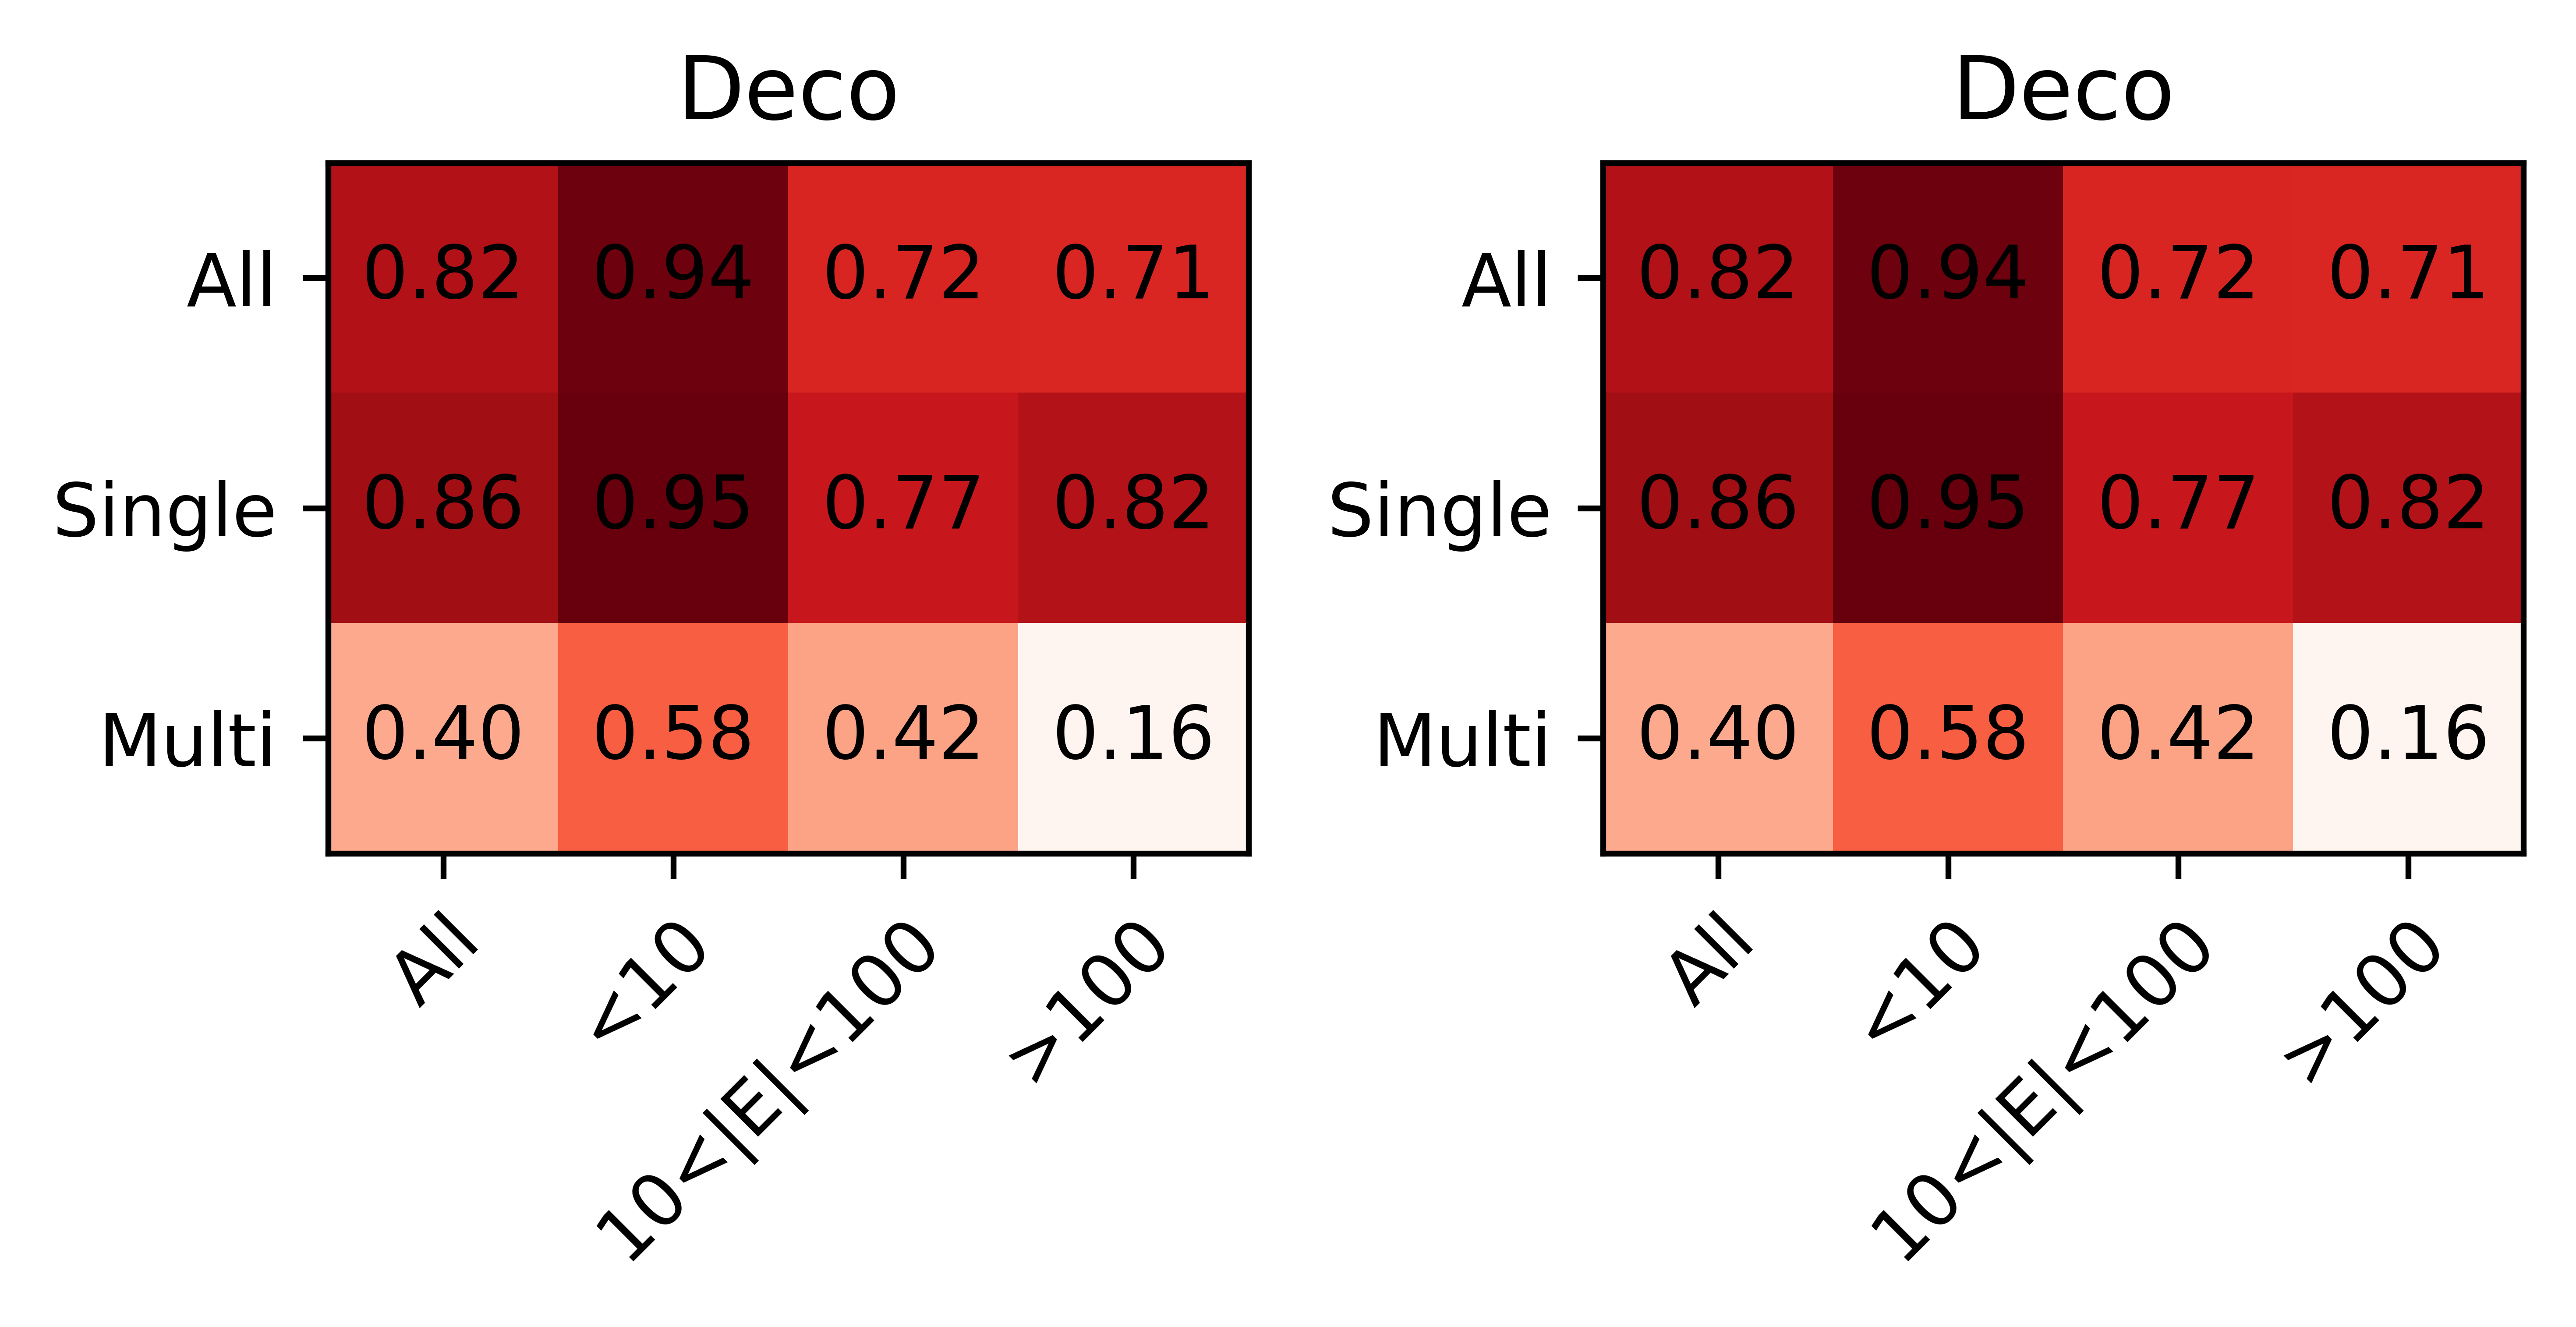

In [9]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm


fig, axes = plt.subplots(1,2, figsize=(5,3), dpi=1200)

for i, ax in enumerate(axes):
    dataset_name = "Deco"
    df = im_dataframes[dataset_name]
    file_types = list(df.index)
    edge_counts = list(df.columns)

    data = df.to_numpy()


    im = ax.imshow(data, cmap=cm.Reds)

    # We want to show all ticks...
    ax.set_xticks(np.arange(len(edge_counts)))
    ax.set_yticks(np.arange(len(file_types)))
    # ... and label them with the respective list entries
    ax.set_xticklabels(edge_counts)
    ax.set_yticklabels(file_types)

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    for i in range(len(file_types)):
        for j in range(len(edge_counts)):
            text = ax.text(j, i, str(data[i, j])[:4],
                           ha="center", va="center", color="black")

    ax.set_title(dataset_name)
# fig.suptitle("Accuracies w noise over filetype and edge count")
fig.tight_layout()
plt.show()

In [ ]:
from statistics import mean, stdev, StatisticsError
import matplotlib.pyplot as plt

for dataset in DATASETS:
    fig, axes = plt.subplots(1,3, figsize=(10, 5))
    print(dataset)
    for noise in [False, True]:
        noise_part = "" if not noise else " + N"
        print("\tGE" + noise_part + "\t\tOriginal\t\t\tImproved")
        original = get_accuracies(dataset, noise, False, "")
        improved = get_accuracies(dataset, noise, True, improvement_type)
        for i, label in enumerate(["All", "Single", "Multi"]):
            or_accuracies = original[i].values()
            or_accuracies = [acc for edge_count_acc in or_accuracies for acc in edge_count_acc]

            im_accuracies = improved[i].values()
            im_accuracies = [acc for edge_count_acc in im_accuracies for acc in edge_count_acc]
            try:
                print(f"\t\t{label}:\t{mean(or_accuracies)}\t{mean(im_accuracies)}")
            except StatisticsError:
                pass
            axes[i].boxplot(
                [or_accuracies, im_accuracies],
                labels=["Original" + noise_part, "Improved" + noise_part],
                showmeans=True,
                positions=[0 + noise, 3 + noise],
            )
            axes[i].set_title(label)
            axes[i].tick_params(labelrotation=45)
    
    fig.suptitle(dataset)
    fig.tight_layout()

In [ ]:
from statistics import mean, stdev, StatisticsError

for dataset in DATASETS:
    print(dataset)
    fig, axes = plt.subplots(1,3, figsize=(10, 5))
    for noise in [False, True]:
        noise_part = "" if not noise else " + N"
        print("\tGE" + noise_part + "\t\tOriginal\t\t\tImproved")
        original = get_accuracies(dataset, noise, False, "")
        improved = get_accuracies(dataset, noise, True, improvement_type)

        or_by_edge_count = {}
        im_by_edge_count = {}
        for i, label in enumerate(["Multi"]):
            for key, values in original[i].items():
                or_by_edge_count[key] = or_by_edge_count.get(key, []) + values
            for key, values in improved[i].items():
                im_by_edge_count[key] = im_by_edge_count.get(key, []) + values

        for i, key in enumerate(or_by_edge_count.keys()):
            try:
                print(f"\t\t{key}:\t{mean(or_by_edge_count[key])}\t{mean(im_by_edge_count[key])}")
            except StatisticsError:
                pass

            axes[i].boxplot(
                [or_by_edge_count[key], im_by_edge_count[key]],
                labels=["Original" + noise_part, "Improved" + noise_part],
                showmeans=True,
                positions=[1 + noise, 3 + noise]
            )
            axes[i].set_title(key)
            axes[i].tick_params(labelrotation=45)
        fig.suptitle(dataset)

In [ ]:
from statistics import mean, stdev, StatisticsError

for dataset in DATASETS:
    print(dataset)
    fig, axes = plt.subplots(1,3, figsize=(10, 5))
    for noise in [False, True]:
        noise_part = "" if not noise else " + N"
        print("\tGE" + noise_part + "\t\tOriginal\t\t\tImproved")
        original = get_accuracies(dataset, noise, False, "")
        improved = get_accuracies(dataset, noise, True, improvement_type)

        or_by_edge_count = {}
        im_by_edge_count = {}
        for i, label in enumerate(["All", "Single", "Multi"]):
            for key, values in original[i].items():
                or_by_edge_count[key] = or_by_edge_count.get(key, []) + values
            for key, values in improved[i].items():
                im_by_edge_count[key] = im_by_edge_count.get(key, []) + values

        for i, key in enumerate(or_by_edge_count.keys()):
            try:
                print(f"\t\t{key}:\t{mean(or_by_edge_count[key])}\t{mean(im_by_edge_count[key])}")
            except StatisticsError:
                pass

            axes[i].boxplot(
                [or_by_edge_count[key], im_by_edge_count[key]],
                labels=["Original" + noise_part, "Improved" + noise_part],
                showmeans=True,
                positions=[1 + noise, 3 + noise]
            )
            axes[i].set_title(key)
            axes[i].tick_params(labelrotation=45)
        fig.suptitle(dataset)

In [ ]:
from statistics import mean, stdev, StatisticsError
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt

for dataset in DATASETS:
    # print(dataset)
    for noise in [False, True]:
        noise_part = "" if not noise else " + N"
        # print("\tGE" + noise_part)
        
        # A List of three Tuples, first part the original acc, second the improved
        # The tuples in order: All, Single, Multi Accuracies
        accuracies = zip(
            get_accuracies(dataset, noise, False, ""),
            get_accuracies(dataset, noise, True, improvement_type),
        )
            
        edge_colors = ["blue", "red"]
        fill_colors = ["cyan", "pink"]

        imp_patch = mpatches.Patch(color='cyan', label='Org. Acc')
        org_patch = mpatches.Patch(color='pink', label='Imp. Acc')

        fig, axes = plt.subplots(1,3, figsize=(15,5))

        for i, accuracies in enumerate(accuracies):
            ax = axes[i]
            ax.set_title(["All", "Single", "Multi"][i])
            original, improved = accuracies
            
            for j, accuracies in enumerate([original, improved]):
                bp = ax.boxplot(
                    accuracies.values(),
                    labels=[f"{key}" for key in accuracies.keys()],
                    positions=[1 + j, 4 + j, 7 + j],
                    patch_artist=True,
                )
                for element in ['boxes', 'whiskers', 'fliers', 'caps']:
                    plt.setp(bp[element], color=edge_colors[j])
                plt.setp(bp["means"], color="black")
                plt.setp(bp['medians'], color="black")
                
                for patch in bp['boxes']:
                    patch.set(facecolor=fill_colors[j])
            
        fig.tight_layout(pad=1, w_pad=2.0, h_pad=2.0)
        title = f"{dataset} - GE" + noise_part
        plt.suptitle(title, x = 0)
        plt.legend(handles=[org_patch, imp_patch])
        plt.show()
        """
            try:
                print(key)
                print(f"\t\tAll: {mean(all_accuracies[key])} +- {stdev(all_accuracies[key])}")
                print(f"\t\tSingle: {mean(single_accuracies[key])} +- {stdev(single_accuracies[key])}")
                print(f"\t\tMulti: {mean(multi_accuracies[key])} +- {stdev(multi_accuracies[key])}")
            except StatisticsError:
                pass
        """

Trying to investigate why multi table precision is so much lower than in the paper

In [ ]:
import matplotlib.pyplot as plt
fg, axes = plt.subplots(2, 3)
for i, experiment in enumerate(get_experiment_paths("Deco", True)):
    multi_table = [(key, acc) for key, acc in file_accuracies(experiment).items() if is_multi_key(key, "Deco")]
    single_table = [(key, acc) for key, acc in file_accuracies(experiment).items() if not is_multi_key(key, "Deco")]
    
    multi_table = (sorted(multi_table, key=lambda x: x[1]))
    single_table = (sorted(single_table, key=lambda x: x[1]))
    
    axes[0][i].hist([v for _, v in single_table])
    axes[0][i].set_title("Single")
    axes[1][i].hist([v for _, v in multi_table])
    axes[1][i].set_title("Multi")
    


In [ ]:
import matplotlib.pyplot as plt


fig, (ax1, ax2) = plt.subplots(2)
fig.tight_layout()
for j, dataset in enumerate(DATASETS):
    accuracies = {}
    table_counts = {}
    edge_counts = {}
    for seed, experiment in enumerate(get_experiment_paths(dataset, True)):
        for key, acc in file_accuracies(experiment).items():
            if not is_multi_key(key, dataset):
                continue
            accuracies[key] = accuracies.get(key, []) + [acc]
            table_counts[key] = refined_data[dataset][key]["table_count"]
            edge_counts[key] = refined_data[dataset][key]["edge_count"]
        
    for key, accs in accuracies.items():
        accuracies[key] = mean(accs)
    
    
    table_count_to_accs = {}
    for key, tc in table_counts.items():
        table_count_to_accs[tc] = table_count_to_accs.get(tc, []) + [accuracies[key]]

    for key, accs in table_count_to_accs.items():
        table_count_to_accs[key] = mean(accs)

    edge_counts_to_accs = {}
    for key, ec in edge_counts.items():
        edge_counts_to_accs[ec] = edge_counts_to_accs.get(ec, []) + [accuracies[key]]
    
    for key, accs in edge_counts_to_accs.items():
        edge_counts_to_accs[key] = mean(accs)
    
    table_count_and_acc = sorted(table_count_to_accs.items(), key=lambda x: x[0])
    edge_counts_and_acc = sorted(edge_counts_to_accs.items(), key=lambda x: x[0])
    
    ax1.plot([x[0] for x in table_count_and_acc], [x[1] for x in table_count_and_acc], label=dataset)
    ax1.set_title("Table_count")
    ax2.plot([x[0] for x in edge_counts_and_acc], [x[1] for x in edge_counts_and_acc], label=dataset)
    ax2.set_title("Edge Count")
ax1.legend()
ax2.legend()

Distribution EdgeCount Single Table File Multi Table File

In [ ]:
import matplotlib.pyplot as plt

for dataset in DATASETS:
    edge_counts_muti_table = []
    edge_counts_single_table = []
    for file_key, data in refined_data[dataset].items():
        edge_count = get_edge_count(file_key, dataset)
        if is_multi_key(file_key, dataset):
            edge_counts_muti_table.append(edge_count)
        else:
            edge_counts_single_table.append(edge_count)
    
    fig, ax = plt.subplots()

    ax.hist(
        [edge_counts_muti_table, edge_counts_single_table],
        stacked=True,
        label=["multi", "single"],
        bins=[i * 10 for i in range(250)]
    )

    ax.set_ylabel('#sheets')
    ax.set_yscale("log")
    ax.set_xlabel('#edges')
    ax.set_title(f'{dataset}: Distribution of multi and single table sheets over edge count')
    ax.legend()

    plt.show()

In [ ]:
import matplotlib.pyplot as plt

for dataset in DATASETS:
    edge_counts_muti_table = []
    edge_counts_single_table = []
    for file_key, data in refined_data[dataset].items():
        edge_count = get_edge_count(file_key, dataset)
        if is_multi_key(file_key, dataset):
            edge_counts_muti_table.append(edge_count)
        else:
            edge_counts_single_table.append(edge_count)
    
    fig, ax = plt.subplots()

    ax.hist(
        [edge_counts_muti_table, edge_counts_single_table],
        stacked=True,
        label=["multi", "single"],
        bins=[i * 10 for i in range(11)]
    )

    ax.set_ylabel('#sheets')
    ax.set_yscale("log")
    ax.set_xlabel('#edges')
    ax.set_title(f'{dataset}: Distribution of multi and single table sheets over edge count')
    ax.legend()

    plt.show()

Getting an estimate on whether label region count correlates with "multi table"ism 

In [ ]:

plt.rcParams["figure.figsize"] = (20,3)

for dataset in DATASETS:
    
    single_label_region_counts = []
    single_edge_counts = []
    single_densities = []
    
    multi_label_region_counts = []
    multi_edge_counts = []
    multi_densities = []
    
    for file_key, data in refined_data[dataset].items():
        table_count = data["table_count"]
        label_region_count = data["label_region_count"]
        edge_count = data["edge_count"]

        if table_count == 1:
            single_label_region_counts.append(label_region_count)
            single_edge_counts.append(edge_count)
            single_densities.append((2 * edge_count) / (label_region_count * (label_region_count - 1)))
        else:
            multi_label_region_counts.append(label_region_count)
            multi_edge_counts.append(edge_count)
            multi_densities.append((2 * edge_count) / (label_region_count * (label_region_count - 1)))
    """
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
    ax1.scatter(single_edge_counts, [1 for _ in range(len(single_edge_counts))], alpha=0.5, label="Single")
    ax1.scatter(multi_edge_counts, [2 for _ in range(len(multi_edge_counts))], alpha=0.5, label="Multi")
    ax1.set_xlabel("Edge Counts")
    ax1.legend()
    
    ax2.scatter(single_label_region_counts, [1 for _ in range(len(single_label_region_counts))], alpha=0.5, label="Single")
    ax2.scatter(multi_label_region_counts, [2 for _ in range(len(multi_label_region_counts))], alpha=0.5, label="Multi")
    ax2.set_xlabel("Label Region Counts")
    ax2.legend()
    
    ax3.scatter(single_densities, [1 for _ in range(len(single_densities))], alpha=0.5, label="Single")
    ax3.scatter(multi_densities, [2 for _ in range(len(multi_densities))], alpha=0.5, label="Multi")
    ax3.set_xlabel("Density")
    ax3.legend()

    fig.suptitle(dataset)
    """ 
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey=True)
    ax1.boxplot([single_edge_counts, multi_edge_counts], labels=["Single", "Multi"], vert=False)
    ax1.set_xlabel("Edge Counts")
    ax1.set_xscale("log")
    
    ax2.boxplot([single_label_region_counts, multi_label_region_counts], labels=["Single", "Multi"], vert=False)
    ax2.set_xlabel("Label Region Counts")
    ax2.set_xscale("log")
    
    ax3.boxplot([single_densities, multi_densities], labels=["Single", "Multi"], vert=False)
    ax3.set_xlabel("Density")
    fig.suptitle(dataset)

In [ ]:

plt.rcParams["figure.figsize"] = (5,2)

for dataset in DATASETS:
    
    single_label_region_counts = []
    single_edge_counts = []
    single_densities = []
    
    multi_label_region_counts = []
    multi_edge_counts = []
    multi_densities = []
    
    for file_key, data in refined_data[dataset].items():
        table_count = data["table_count"]
        label_region_count = data["label_region_count"]
        edge_count = data["edge_count"]

        if table_count == 1:
            single_label_region_counts.append(label_region_count)
            single_edge_counts.append(edge_count)
            single_densities.append((2 * edge_count) / (label_region_count * (label_region_count - 1)))
        else:
            multi_label_region_counts.append(label_region_count)
            multi_edge_counts.append(edge_count)
            multi_densities.append((2 * edge_count) / (label_region_count * (label_region_count - 1)))

    fig, (ax3) = plt.subplots(1, 1, sharey=True)
    
    ax3.boxplot([single_densities, multi_densities], labels=["Single", "Multi"], vert=False)
    ax3.set_xlabel("Density")
    fig.suptitle(dataset)